In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf    # extra added line
import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax, MaxPool1D
from keras.layers import GlobalAveragePooling1D     # extra added line
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D    # extra added line 
# from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
#imports to apply k-fold validation
from sklearn.model_selection import KFold, cross_val_score

import seaborn as sns
from typing import Tuple
import copy as cp
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [5]:
path = 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()



In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [7]:
print((filenames))
records_list_16 = ['100', '106', '107', '109', '111', '118', '124', '200', '201', '207', '208', '209', '212', '214', '231', '233']
annotations_list_16 = ['100', '106', '107', '109', '111', '118', '124', '200', '201', '207', '208', '209', '212', '214', '231', '233']

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [8]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
print(len(records))
print(len(annotations))
records

48
48


['E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/100.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/101.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/102.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/103.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/104.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/105.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/106.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/107.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/108.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/P3/mitbih_database/mitbih_database/109.csv',
 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/

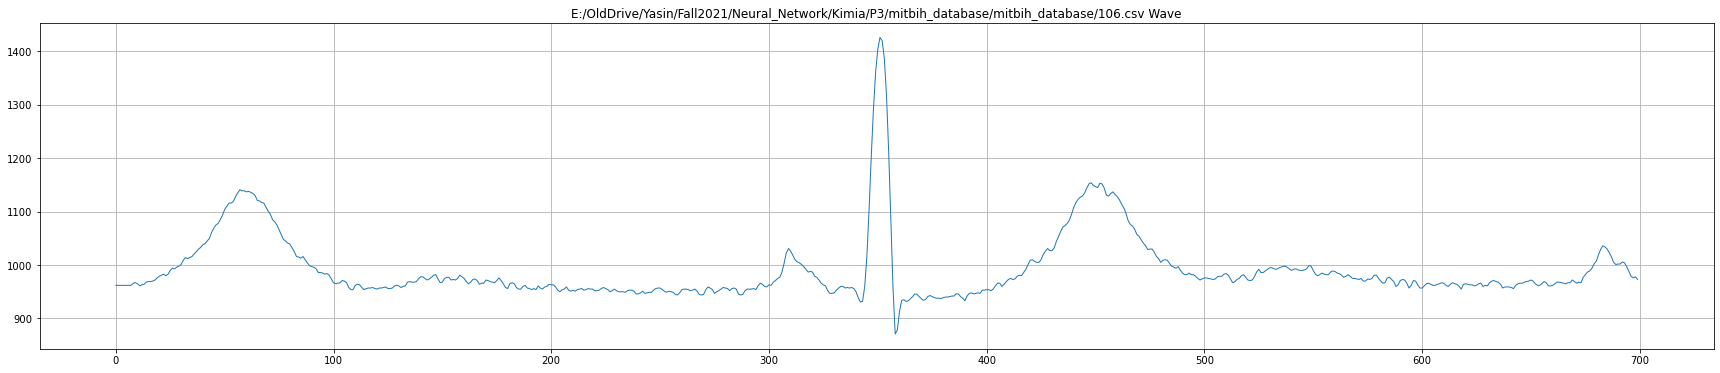

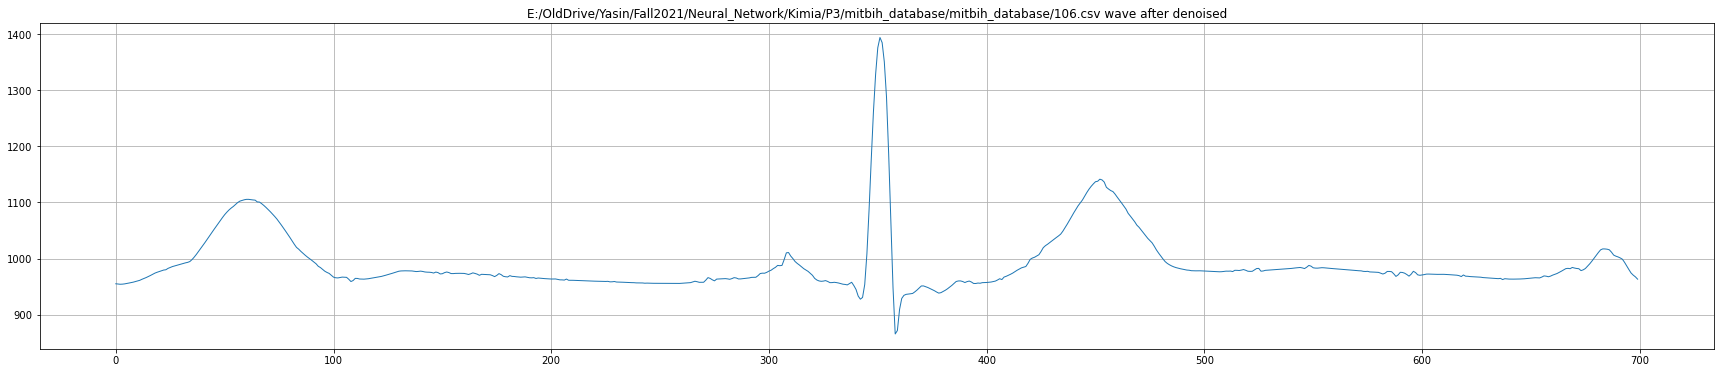

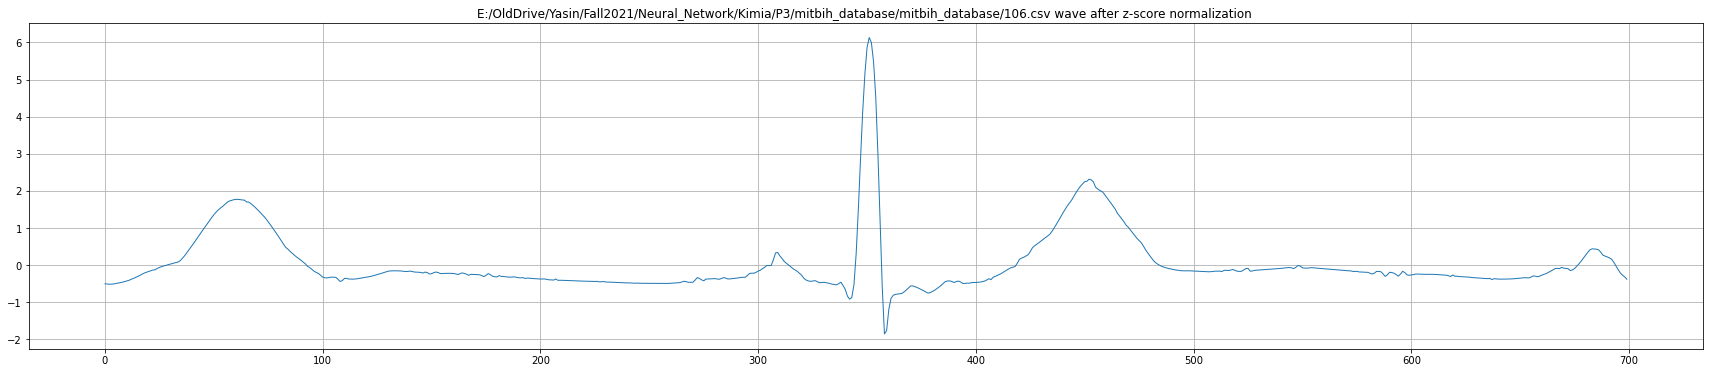

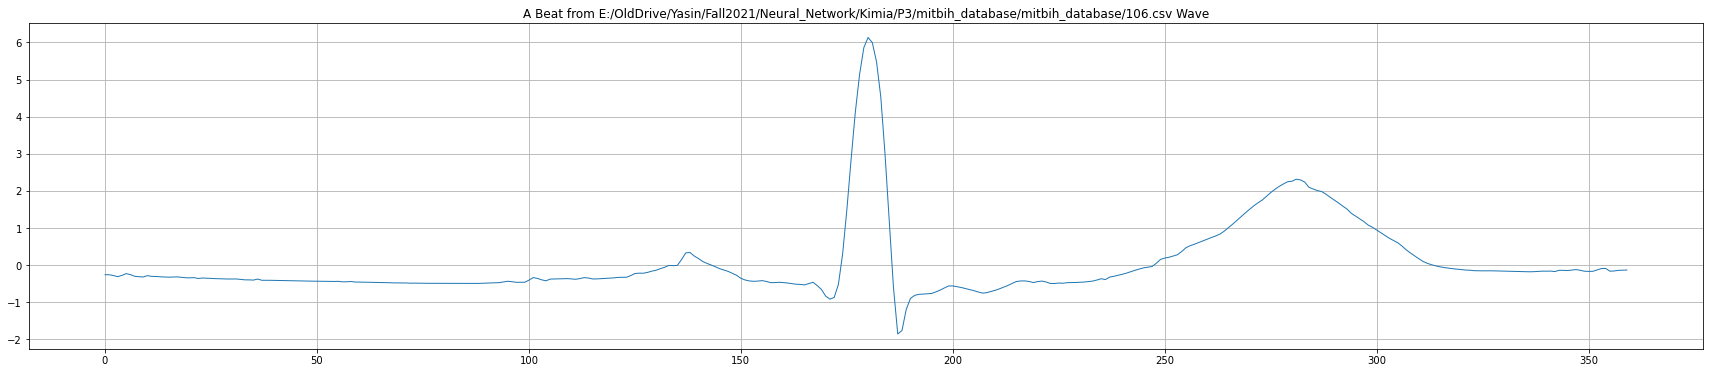

(100012, 360) (100012,)


In [10]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [11]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution¶


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


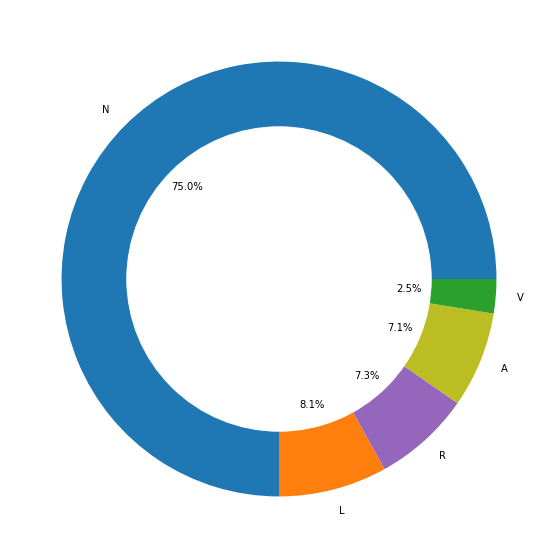

In [12]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:


df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=6000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=6000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=6000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=6000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=6000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])



4.0    6000
3.0    6000
2.0    6000
1.0    6000
0.0    6000
Name: 360, dtype: int64


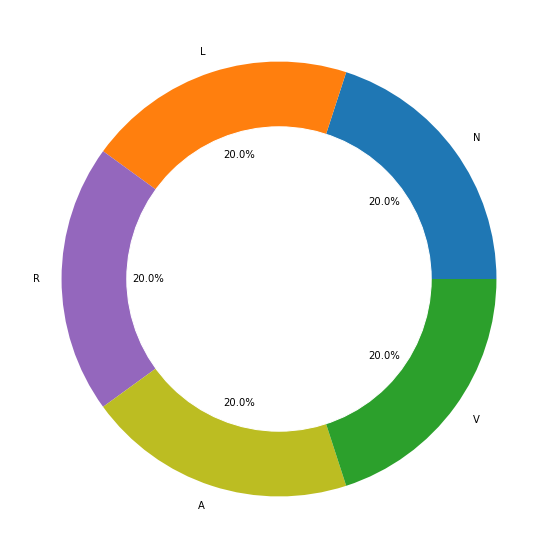

In [14]:


per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()



In [15]:


train, test = train_test_split(X_train_df, test_size=0.20,random_state = 42)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))



X_train :  (24000, 361)
X_test  :  (6000, 361)


In [16]:


target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))



(24000, 5) (6000, 5)


In [17]:


train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))



(24000, 360, 1) (6000, 360, 1)


# Building the MODIFIED Model Architecture¶


In [18]:
# Instanciate an empty model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=9,  padding='same', activation='relu',input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=24, kernel_size=11, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=56, kernel_size=13, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=96, kernel_size=15, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Dropout(0.5))
model.add(Conv1D(5, kernel_size=9, padding='same', activation='relu'))    # here 5 is no of classes, i.e classes in output
model.add(GlobalAveragePooling1D())
model.add(Softmax())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 16)           160       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 24)           4248      
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 24)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 56)            17528     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 56)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 96)            8

In [19]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [20]:
history = model.fit(train_x, train_y, batch_size=36, epochs=20, verbose=1, validation_data=(test_x, test_y))

Epoch 1/20
667/667 [==============================] - 10s 6ms/step - loss: 0.6075 - accuracy: 0.7778 - val_loss: 0.3452 - val_accuracy: 0.8993
Epoch 2/20
667/667 [==============================] - 4s 6ms/step - loss: 0.2308 - accuracy: 0.9253 - val_loss: 0.1768 - val_accuracy: 0.9427
Epoch 3/20
667/667 [==============================] - 4s 7ms/step - loss: 0.1615 - accuracy: 0.9454 - val_loss: 0.1199 - val_accuracy: 0.9610
Epoch 4/20
667/667 [==============================] - 4s 7ms/step - loss: 0.1313 - accuracy: 0.9541 - val_loss: 0.1239 - val_accuracy: 0.9582
Epoch 5/20
667/667 [==============================] - 4s 6ms/step - loss: 0.1169 - accuracy: 0.9611 - val_loss: 0.0791 - val_accuracy: 0.9757
Epoch 6/20
667/667 [==============================] - 4s 6ms/step - loss: 0.0980 - accuracy: 0.9680 - val_loss: 0.0745 - val_accuracy: 0.9733
Epoch 7/20
667/667 [==============================] - 4s 6ms/step - loss: 0.0927 - accuracy: 0.9689 - val_loss: 0.0656 - val_accuracy: 0.9807
Epoch

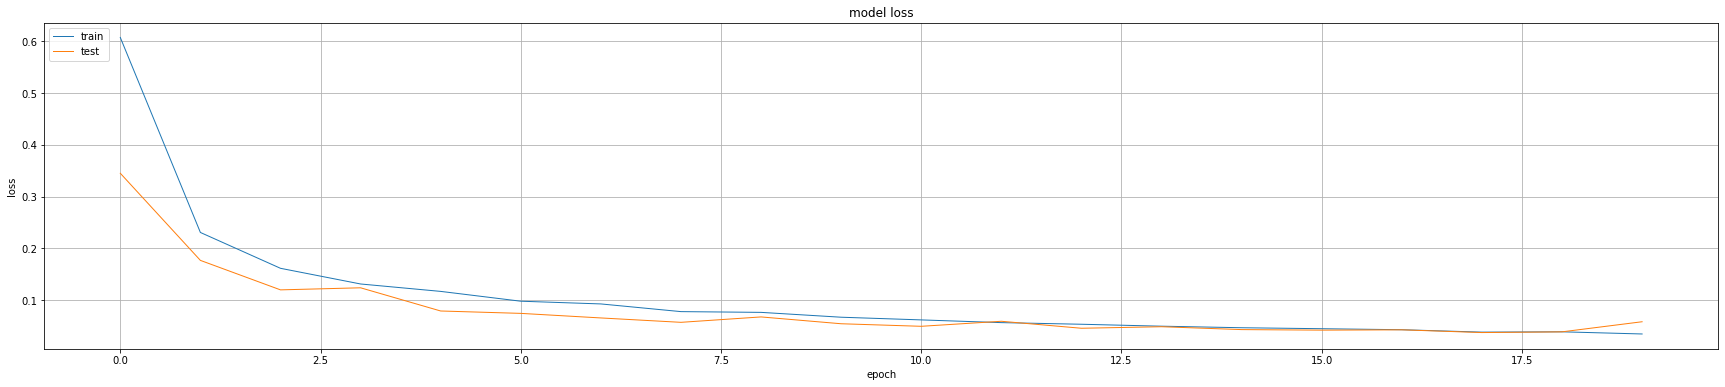

In [21]:


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



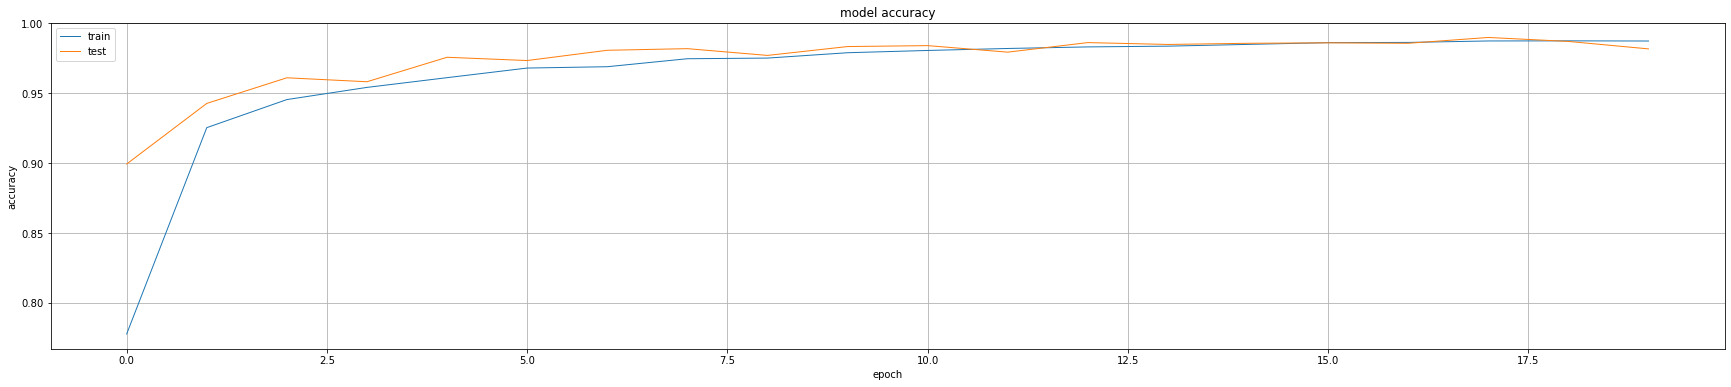

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:


score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])



188/188 [==============================] - 2s 3ms/step - loss: 0.0583 - accuracy: 0.9817
Test Loss: 0.05830223113298416
Test accuracy: 0.9816666841506958


In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

           N       0.98      0.95      0.96      1179
           L       1.00      1.00      1.00      1244
           R       0.99      1.00      0.99      1216
           A       0.95      0.98      0.96      1171
           V       1.00      0.98      0.99      1190

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



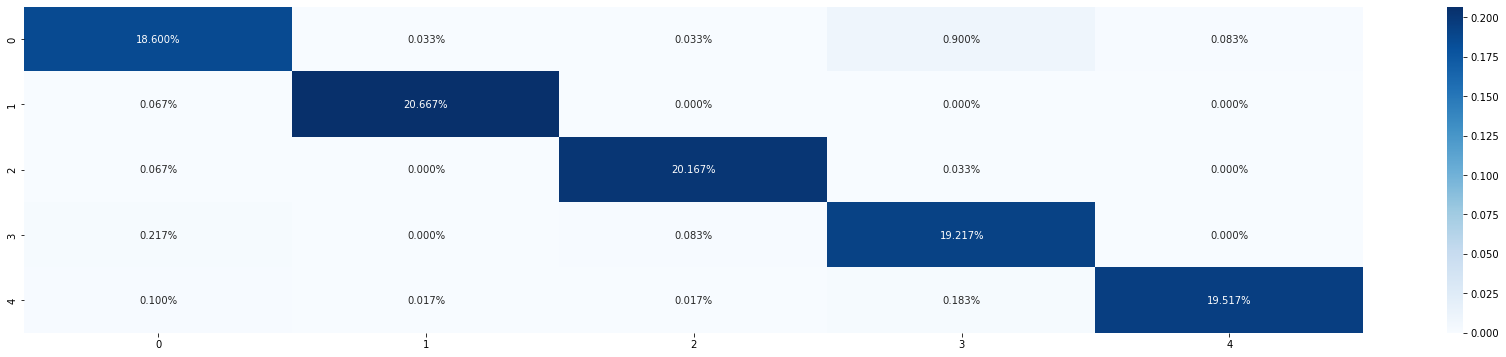

In [32]:
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
print(classification_report(y_true, prediction, target_names=classes))
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [28]:


print('Precision: %.3f' % precision_score(y_true, prediction, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true, prediction, average='micro'))
print('Recall: %.3f' % recall_score(y_true, prediction, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true, prediction))



Precision: 0.982
F1 Score: 0.982
Recall: 0.982
Accuracy: 0.982
